<a href="https://colab.research.google.com/github/Joe-Ol/introtodeeplearning/blob/master/TFLite/Arduino/tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers

In [2]:
print(np.__version__)
print(tf.__version__)
print(tf.keras.__version__)

1.18.5
2.3.0
2.4.0


In [3]:
nsamples = 1000 #no. of samples to use as dataset
val_ratio = 0.2 #amount for validation set
test_ratio = 0.2  #amount for test set
tflite_model_name = 'sine_model'  #will be given .tflite suffix
c_model_name = 'sine_model' #will be given .h suffix

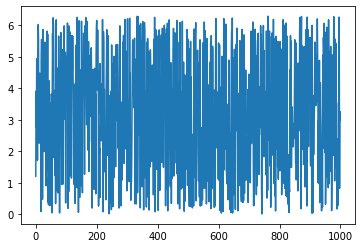

In [4]:
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2*math.pi), size=nsamples)
plt.plot(x_values)


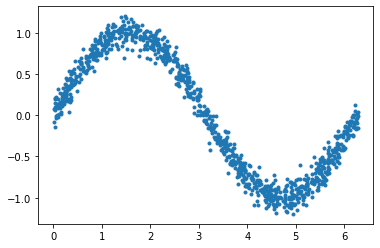

In [11]:
#create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1*np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

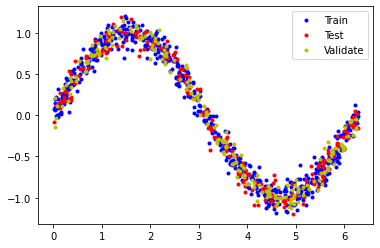

In [12]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [14]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [15]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [16]:
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 0s 22ms/step - loss: 0.5932 - mae: 0.5932 - val_loss: 0.5165 - val_mae: 0.5165
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 0.5269 - mae: 0.5269 - val_loss: 0.5062 - val_mae: 0.5062
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 0.5158 - mae: 0.5158 - val_loss: 0.4992 - val_mae: 0.4992
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 0.5065 - mae: 0.5065 - val_loss: 0.4904 - val_mae: 0.4904
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4980 - mae: 0.4980 - val_loss: 0.4840 - val_mae: 0.4840
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4876 - mae: 0.4876 - val_loss: 0.4749 - val_mae: 0.4749
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4787 - mae: 0.4787 - val_loss: 0.4653 - val_mae: 0.4653
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4672 - mae: 0.4672 - va

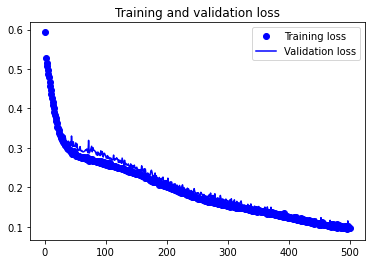

In [17]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

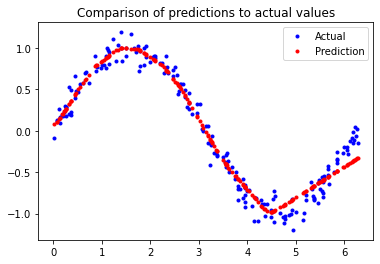

In [18]:

# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [20]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmps3rqycy1/assets


INFO:tensorflow:Assets written to: /tmp/tmps3rqycy1/assets


2928

In [21]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [22]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))